In [20]:
###################################
## Goal: Develop a basic outline so they we can devide and concur different parts of the project

## Note: All functions will be explicitly defined within this file for ease. In actual implementation it will be stored in a Function.py
###################################

In [21]:
##### Some Update Timelines
### 11/10/2024 - Implementing the monthly data into our series - Our Strategy now goes back to 1975. 
### TO DO: Implement it back to 1973

In [22]:
'''
Roadmap

1.Build out a portfolio A based on a traditional 60/40 asset allocation with bloomberg ticker LUATTRUU Index for the 40% bond allocation. 
The bloomberg terminal has monthly data starting 1973 and daily data starting in 1994. For the 60% equities, use bloomberg ticker SPXT Index with data starting in 1989 and 
SPX Index going back to 1973 (it would be nice but not necessary to find S&P 500 total return data prior to 1989).

2.Record:
•	Compound annualized growth
•	Annualized volatility
•	Annualized downside deviation
•	Max drawdown each year
•	Annualized Sharpe Ratio
•	Annualized Sortino Ratio
•	Annualized Omega Ratio
•	Annualized Calmar Ratio

3.  Backtest an alternative Portfolio B with size of this allocation adjustable and using data going back to 1972. 
Initially, the alternative strategy should be the XAU trade model outlined below, with the potential to test other alternative strategies in the future. 
Record monthly performance of Portfolio B over the course of historical backtest and record the same overall performance metrics used for Portfolio A
Use ticker XAU Curncy and SPX Index. The trade trigger is XAU bull trend aligned simultaneously with SPX/XAU ratio bear trend. 
The trade triggers and exits can be optimized based on any combination of smoothed moving average crosses. 5,20,63,252 using daily data. 4,13,52 using weekly closing price data. 
3 and 12 for monthly closing data.

Trade trigger examples: 
•	20 day < 252 day  for SPX/XAU and then on day 20 crosses > 252 for XAU, the model goes long XAU
•	4 week > 13 week for XAU and then when the 4 week crosses below the 13 week moving avg for SPX/XAU, the model goes long XAU 

4.  Combine Portfolio A with Portfolio B to create Portfolio C using an initial 10% allocation (if 60/40 portfolio size = $100 then alt strategy =$10)  
If initial findings do not reflect the XAU trade model being beneficial to adding resiliency to the initial portfolio, please reach out and we will provide other alternative strategy ideas.


'''

'\nRoadmap\n\n1.Build out a portfolio A based on a traditional 60/40 asset allocation with bloomberg ticker LUATTRUU Index for the 40% bond allocation. \nThe bloomberg terminal has monthly data starting 1973 and daily data starting in 1994. For the 60% equities, use bloomberg ticker SPXT Index with data starting in 1989 and \nSPX Index going back to 1973 (it would be nice but not necessary to find S&P 500 total return data prior to 1989).\n\n2.Record:\n•\tCompound annualized growth\n•\tAnnualized volatility\n•\tAnnualized downside deviation\n•\tMax drawdown each year\n•\tAnnualized Sharpe Ratio\n•\tAnnualized Sortino Ratio\n•\tAnnualized Omega Ratio\n•\tAnnualized Calmar Ratio\n\n3.  Backtest an alternative Portfolio B with size of this allocation adjustable and using data going back to 1972. \nInitially, the alternative strategy should be the XAU trade model outlined below, with the potential to test other alternative strategies in the future. \nRecord monthly performance of Portfolio

In [23]:
# Packages
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import import_ipynb
from tqdm import tqdm
import numpy as np
import pandas as pd
import quantstats as qs 
import sys
import os

# Check directory
print("Current Working Directory:", os.getcwd())

# Set pandas display precision to three decimal places
pd.options.display.float_format = '{:.4f}'.format

Current Working Directory: c:\Users\neoel\OneDrive - The University of Chicago\PL_Low_Tide_Capital_MGMT\Code


In [24]:
# Read in Data
data = pd.read_excel('equity_bond_gold.xlsx', na_values=['#N/A N/A'], sheet_name='equity_bond_gold_price')

# Rename the specified columns
data = data.rename(columns={
    'LUATTRUU Index': 'Bond',
    'SPXT Index': 'SP500_tr',
    'SPX Index': 'SP500',
    'XAU Curncy': 'Gold'
})

data.head(2)

,Dates,Bond,SP500_tr,SP500,Gold
0,1973-02-01,98.9900,NaN,114.7600,65.1400
1,1973-02-02,98.9900,NaN,114.3500,65.1400


In [25]:
'''
THESE ARE GENERAL NOTES ABOUT OUR DATA:
1) Our BOND DATA does not become daily until 03-01-1994
2) Our GOLD DATA does not become daily until 01-01-1975
-- THIS ABOVE FACT IS KEY -> Looking above we can see that this would have been a prime moment to invest in gold therefore we would like to showcase this in our portfolio
-- We will need to split our trend analysis that is for the first two years use monthly data and then convert into monthly
3) Our SP500 TR (which includes dividends) only begin in 09-11-1989 
-- THIS creates a problem for reporting the true return of the base port (CURRENTLY WE ARE ONLY USING PRICE RETURNS)
'''

'\nTHESE ARE GENERAL NOTES ABOUT OUR DATA:\n1) Our BOND DATA does not become daily until 03-01-1994\n2) Our GOLD DATA does not become daily until 01-01-1975\n-- THIS ABOVE FACT IS KEY -> Looking above we can see that this would have been a prime moment to invest in gold therefore we would like to showcase this in our portfolio\n-- We will need to split our trend analysis that is for the first two years use monthly data and then convert into monthly\n3) Our SP500 TR (which includes dividends) only begin in 09-11-1989 \n-- THIS creates a problem for reporting the true return of the base port (CURRENTLY WE ARE ONLY USING PRICE RETURNS)\n'

In [26]:
########################################  
# Our GOLD DATA does not become daily until 01-01-1975
data = data[data['Dates'] >= '1975-01-01']
########################################

data.head(2)

,Dates,Bond,SP500_tr,SP500,Gold
499,1975-01-01,110.8100,NaN,68.5600,183.8500
500,1975-01-02,110.8100,NaN,70.2300,175.0000


In [27]:
# Although we will report with monthly data we need daily data to calculate the return of our strategy
def calc_percent(df):
    """
    Calculate the percentage change for each column in the DataFrame, ensuring DateTime indexing.
    """
    # Set 'Dates' column as the index and convert to DateTime if not already
    if 'Dates' in df.columns:
        df['Dates'] = pd.to_datetime(df['Dates'])
        df.set_index('Dates', inplace=True)
    
    # Create a new DataFrame for the percentage changes, maintaining the DateTime index
    df_percent = pd.DataFrame(index=df.index)
    
    # Calculate the percentage change for each column and add it to the new DataFrame
    for col in df.columns:
        df_percent[col + '_pctchange'] = df[col].pct_change().fillna(0)
    
    return df_percent


# Calculate percentage changes for each column starting from the second column onward
returns_daily = calc_percent(data)
returns_daily


,Bond_pctchange,SP500_tr_pctchange,SP500_pctchange,Gold_pctchange
Dates,,,,
1975-01-01,0.0000,0.0000,0.0000,0.0000
1975-01-02,0.0000,0.0000,0.0244,-0.0481
1975-01-03,0.0000,0.0000,0.0068,-0.0057
1975-01-06,0.0000,0.0000,0.0051,-0.0029
1975-01-07,0.0000,0.0000,-0.0007,-0.0231
...,...,...,...,...
2024-10-28,-0.0013,0.0027,0.0027,-0.0019
2024-10-29,0.0006,0.0016,0.0016,0.0118
2024-10-30,-0.0006,-0.0033,-0.0033,0.0046


In [28]:
### Now We will Report Monthly Returns Not Daily Returns so we need to adjust accoirdinly.

# Resample daily data to monthly frequency
def resample_to_monthly(df):
    """
    Resample daily data to monthly data by taking the last available data point in each month.
    """
    # Ensure 'Dates' is datetime and set as index
    if 'Dates' in df.columns:
        df['Dates'] = pd.to_datetime(df['Dates'])
        df.set_index('Dates', inplace=True)
    else:
        df.index = pd.to_datetime(df.index)
    
    # Resample to monthly data, taking the last available data point in each month
    df_monthly = df.resample('ME').last()
    return df_monthly

# Lets Get Our Monthly Data
monthly_data = resample_to_monthly(data)
monthly_data

,Bond,SP500_tr,SP500,Gold
Dates,,,,
1975-01-31,112.0900,NaN,76.9800,175.8000
1975-02-28,113.4600,NaN,81.5900,181.7500
1975-03-31,113.0200,NaN,83.3600,178.1600
1975-04-30,111.4700,NaN,87.3000,167.0000
1975-05-31,113.7100,NaN,91.1500,167.0000
...,...,...,...,...
2024-07-31,2306.8400,12052.0900,5522.3000,2447.6000
2024-08-31,2336.3500,12344.4300,5648.4000,2503.3900
2024-09-30,2364.4400,12608.0700,5762.4800,2634.5800


In [29]:
def calc_monthly_percent_changes(df, from_daily=False):
    """
    Calculate the percentage change for each column in the DataFrame.
    
    Parameters:
    df : pandas DataFrame - The input DataFrame with monthly price data or daily return data.
    from_daily : bool - If True, calculates cumulative monthly returns from daily data.
                       If False, calculates percentage changes for monthly price data.
    """
    if from_daily:
        # Resample daily return data to get cumulative monthly returns
        df_monthly = (1 + df).resample('ME').prod() - 1  # Monthly cumulative return
    else:
        # Assume monthly price data, calculate the monthly percentage change
        df_monthly = df.pct_change().fillna(0)
    
    # Rename columns to indicate percentage change
    df_monthly.columns = [col + '_pctchange' for col in df_monthly.columns]
    
    return df_monthly

# Get Our Monthly Returns
returns_monthly = calc_monthly_percent_changes(monthly_data)

# Add a weighted 'ports_pctchange' column
returns_monthly['ports_pctchange'] = 0.6 * returns_monthly['SP500_pctchange'] + 0.4 * returns_monthly['Bond_pctchange']

returns_monthly.head(5)

,Bond_pctchange,SP500_tr_pctchange,SP500_pctchange,Gold_pctchange,ports_pctchange
Dates,,,,,
1975-01-31,0.0000,0.0000,0.0000,0.0000,0.0000
1975-02-28,0.0122,0.0000,0.0599,0.0338,0.0408
1975-03-31,-0.0039,0.0000,0.0217,-0.0198,0.0115
1975-04-30,-0.0137,0.0000,0.0473,-0.0626,0.0229
1975-05-31,0.0201,0.0000,0.0441,0.0000,0.0345


In [30]:
#### Function to Calculate Port Returns - Note this assumes we are taking in monthly data.

def calculate_max_drawdown(df, column_name):
    """
    Calculate the max drawdown for the entire period in a DataFrame with a DateTime index.
    """
    # Ensure the index is a DateTimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DateTimeIndex.")
    
    cumulative_returns = (1 + df[column_name]).cumprod()  # Calculate cumulative returns
    peak = cumulative_returns.cummax()  # Calculate rolling maximum of cumulative returns
    drawdown = (cumulative_returns - peak) / peak  # Calculate drawdown
    max_drawdown = drawdown.min()  # Return the maximum drawdown
    
    return max_drawdown



def calculate_performance_metrics(df, column_name):
    """
    Calculate various performance metrics for a given DataFrame with a DateTimeIndex.
    The annualization factor is set to 12 for monthly data.
    """
    annualization_factor = 12  # Set annualization factor to 12 for monthly data
    
    # Ensure the specified column exists
    if column_name not in df.columns:
        raise ValueError(f"The DataFrame must contain a '{column_name}' column.")

    # Drop missing values in returns
    returns = df[column_name].dropna()

    # Annualized returns (Compound Annualized Growth Rate - CAGR)
    cumulative_return = (1 + returns).prod() - 1
    years = len(returns) / annualization_factor
    cagr = (1 + cumulative_return) ** (1 / years) - 1
    
    # Annualized volatility
    annualized_volatility = returns.std() * np.sqrt(annualization_factor)

    # Annualized downside deviation (only considers negative returns)
    downside_returns = returns[returns < 0]
    annualized_downside_deviation = downside_returns.std() * np.sqrt(annualization_factor)

    # Annualized Sharpe Ratio (Assuming risk-free rate is zero)
    sharpe_ratio = cagr / annualized_volatility

    # Annualized Sortino Ratio
    sortino_ratio = cagr / annualized_downside_deviation

    # Annualized Omega Ratio (Using threshold of 0 for the numerator)
    positive_excess_returns = returns[returns > 0].sum()
    negative_excess_returns = abs(returns[returns < 0].sum())
    omega_ratio = positive_excess_returns / negative_excess_returns

    # Max drawdown for the full period
    max_drawdown = calculate_max_drawdown(df, column_name)

    # Annualized Calmar Ratio
    calmar_ratio = cagr / abs(max_drawdown)

    # Prepare results as a DataFrame
    metrics_df = pd.DataFrame({
        'Metric': ['CAGR', 'Annualized Volatility', 'Annualized Downside Deviation', 'Sharpe Ratio', 
                   'Sortino Ratio', 'Omega Ratio', 'Max Drawdown', 'Calmar Ratio'],
        'Value': [cagr, annualized_volatility, annualized_downside_deviation, sharpe_ratio, 
                  sortino_ratio, omega_ratio, max_drawdown, calmar_ratio]
    })

    return metrics_df

# Now let us calculate the performance of our base model

base_port_performance = calculate_performance_metrics(returns_monthly, column_name='ports_pctchange')
base_port_performance


,Metric,Value
0,CAGR,0.0821
1,Annualized Volatility,0.0945
2,Annualized Downside Deviation,0.0648
3,Sharpe Ratio,0.8690
4,Sortino Ratio,1.2672
5,Omega Ratio,1.9377
6,Max Drawdown,-0.3191
7,Calmar Ratio,0.2573


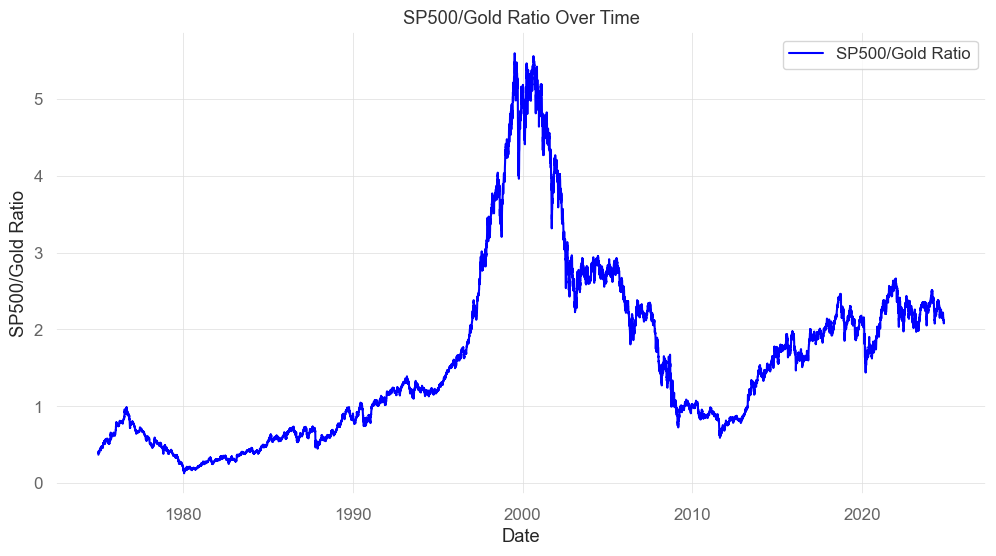

In [31]:
# Calculate the ratio of SP500 to Gold
data['SP500_Gold_Ratio'] = data['SP500'] / data['Gold']
data

# Plotting the SP500_Gold_Ratio
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['SP500_Gold_Ratio'], label='SP500/Gold Ratio', color='blue')
plt.title('SP500/Gold Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('SP500/Gold Ratio')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
def generate_signal(price_series, short1, long1, short2, long2):
    """
    Generates a trading signal based on two EMA crossover strategies.

    Args:
        price_series (Series): The price series to analyze.
        short1 (int): Short-term EMA period for the first strategy.
        long1 (int): Long-term EMA period for the first strategy.
        short2 (int): Short-term EMA period for the second strategy.
        long2 (int): Long-term EMA period for the second strategy.

    Returns:
        DataFrame: DataFrame containing the 'signal' column.
    """
    df = pd.DataFrame(price_series)

    # Calculate EMAs for both strategies
    df['long_ma1'] = price_series.ewm(span=long1, adjust=False).mean()
    df['short_ma1'] = price_series.ewm(span=short1, adjust=False).mean()
    df['long_ma2'] = price_series.ewm(span=long2, adjust=False).mean()
    df['short_ma2'] = price_series.ewm(span=short2, adjust=False).mean()

    # Generate signals: 1 if short_ma > long_ma, 0 otherwise
    df['signal1'] = np.where(df['short_ma1'] > df['long_ma1'], 1, 0)
    df['signal2'] = np.where(df['short_ma2'] > df['long_ma2'], 1, 0)

    # Signal = 1 if both signals are active, 0.5 if only one is active, and 0 if neither are active
    df['signal'] = np.where((df['signal1'] == 1) & (df['signal2'] == 1), 1, 
                        np.where(df['signal1'] != df['signal2'], 0.5, 0))

    # Keep only the 'signal' column
    return df[['signal']]

signal_df = generate_signal(data['Gold'], 20, 63, 50, 200)

signal_tally = signal_df['signal'].value_counts()
print(signal_tally)

signal
1.0000    5751
0.0000    4376
0.5000    2876
Name: count, dtype: int64


In [33]:
def calculate_position_returns(signal_df, returns_series):
    """
    Calculates the returns based on holding positions according to signals, with a one-day delay.
    
    Args:
        signal_df (DataFrame): DataFrame containing the 'signal' column indicating the position (1, 0.5, or 0).
        returns_series (Series): Series of daily returns corresponding to the price series.
    
    Returns:
        DataFrame: DataFrame containing the shifted signals and the resulting position returns.
    """
    # Shift the signal by one day to implement the one-day delay
    signal_df['shifted_signal'] = signal_df['signal'].shift(1)
    
    # Calculate returns by multiplying returns with the delayed signal
    signal_df['position_returns'] = returns_series * signal_df['shifted_signal']
    
    # Optional: Calculate cumulative returns for a summary view
    # signal_df['cumulative_returns'] = (1 + signal_df['position_returns']).cumprod() - 1
    
    return signal_df[['shifted_signal', 'position_returns']]#, 'cumulative_returns']]


##### Currently we are only implementing on GOLD not the relationship so let us make sure that we go back the right amount. 

# Our GOLD DATA does not become daily until 01-01-1975
# returns_monthly = returns_monthly[returns_monthly.index >= '1975-01-01']

# Creating the Gold Strategy Based on Bullish stances on Gold
gold_strategy = calculate_position_returns(signal_df, returns_daily['Gold_pctchange'])
gold_strategy

,shifted_signal,position_returns
Dates,,
1975-01-01,NaN,NaN
1975-01-02,0.0000,-0.0000
1975-01-03,0.0000,-0.0000
1975-01-06,0.0000,-0.0000
1975-01-07,0.0000,-0.0000
...,...,...
2024-10-28,1.0000,-0.0019
2024-10-29,1.0000,0.0118
2024-10-30,1.0000,0.0046


In [34]:
gold_strategy_monthly = calc_monthly_percent_changes(gold_strategy, from_daily= True)

gold_strategy_performance = calculate_performance_metrics(gold_strategy_monthly, column_name='position_returns_pctchange')

leveraged_gold_strategy = pd.DataFrame(
    returns_monthly['ports_pctchange'] + 0.1 * gold_strategy_monthly['position_returns_pctchange'], 
    columns=['Returns']
)

leveraged_gold_strategy_performance = calculate_performance_metrics(leveraged_gold_strategy, column_name='Returns')

# Combine the three DataFrames side-by-side with labeled columns
combined_performance = pd.concat(
    [base_port_performance, gold_strategy_performance, leveraged_gold_strategy_performance],
    axis=1,
    keys=['Base Portfolio', 'Gold Strategy', 'Leveraged Strategy']
)

# Display the combined DataFrame
combined_performance

Base Portfolio                          Gold Strategy  \
                          Metric   Value                         Metric   
0                           CAGR  0.0821                           CAGR   
1          Annualized Volatility  0.0945          Annualized Volatility   
2  Annualized Downside Deviation  0.0648  Annualized Downside Deviation   
3                   Sharpe Ratio  0.8690                   Sharpe Ratio   
4                  Sortino Ratio  1.2672                  Sortino Ratio   
5                    Omega Ratio  1.9377                    Omega Ratio   
6                   Max Drawdown -0.3191                   Max Drawdown   
7                   Calmar Ratio  0.2573                   Calmar Ratio   

                      Leveraged Strategy          
    Value                         Metric   Value  
0  0.0574                           CAGR  0.0890  
1  0.1416          Annualized Volatility  0.0960  
2  0.0996  Annualized Downside Deviation  0.0653  
3  0.4052                   Sharpe Ratio  0.9280  
4  0.5757                  Sortino Ratio  1.3635  
5  1.6066                    Omega Ratio  2.0210  
6 -0.4242                   Max Drawdown -0.3145  
7  0.1352                   Calmar Ratio  0.2831

In [35]:
### Say Instead of placing that money in Gold we were able to lever the SP500 instead
leveraged_sp500_strategy = pd.DataFrame(
    1.1 * returns_monthly['ports_pctchange'] + 0 * gold_strategy_monthly['position_returns_pctchange'], 
    columns=['Returns']
)

leveraged_sp500_strategy_performance = calculate_performance_metrics(leveraged_sp500_strategy, column_name='Returns')

# Combine the three DataFrames side-by-side with labeled columns
combined_performance = pd.concat(
    [leveraged_gold_strategy_performance,leveraged_sp500_strategy_performance],
    axis=1,
    keys=['Leveraged Gold Strategy', 'Levered SP500 Strategy']
)

# Display the combined DataFrame
combined_performance

Leveraged Gold Strategy                 Levered SP500 Strategy  \
                          Metric   Value                         Metric   
0                           CAGR  0.0890                           CAGR   
1          Annualized Volatility  0.0960          Annualized Volatility   
2  Annualized Downside Deviation  0.0653  Annualized Downside Deviation   
3                   Sharpe Ratio  0.9280                   Sharpe Ratio   
4                  Sortino Ratio  1.3635                  Sortino Ratio   
5                    Omega Ratio  2.0210                    Omega Ratio   
6                   Max Drawdown -0.3145                   Max Drawdown   
7                   Calmar Ratio  0.2831                   Calmar Ratio   

           
    Value  
0  0.0901  
1  0.1039  
2  0.0713  
3  0.8670  
4  1.2644  
5  1.9377  
6 -0.3459  
7  0.2605

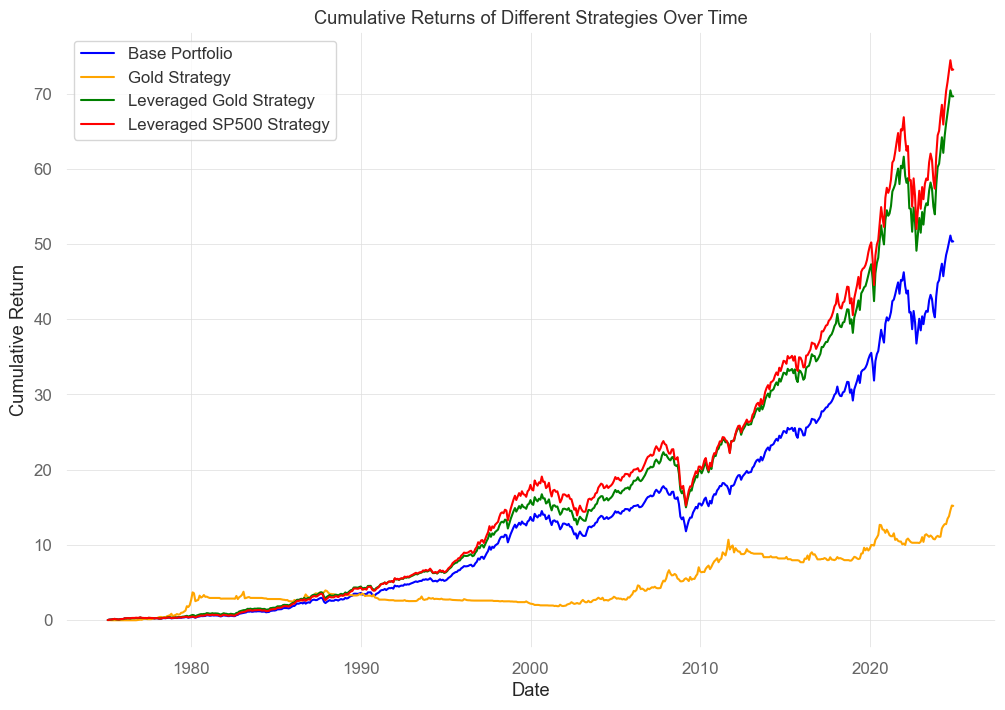

In [36]:
# Creating a cumulative_returns DataFrame that consolidates cumulative returns for each strategy
cumulative_returns = pd.DataFrame({
    'Base Portfolio': (1 + returns_monthly['ports_pctchange']).cumprod() - 1,
    'Gold Strategy': (1 + gold_strategy_monthly['position_returns_pctchange']).cumprod() - 1,
    'Leveraged Gold Strategy': (1 + leveraged_gold_strategy['Returns']).cumprod() - 1,
    'Leveraged SP500 Strategy': (1 + leveraged_sp500_strategy['Returns']).cumprod() - 1
})

# Plotting the cumulative returns
plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns.index, cumulative_returns['Base Portfolio'], label='Base Portfolio', color='blue')
plt.plot(cumulative_returns.index, cumulative_returns['Gold Strategy'], label='Gold Strategy', color='orange')
plt.plot(cumulative_returns.index, cumulative_returns['Leveraged Gold Strategy'], label='Leveraged Gold Strategy', color='green')
plt.plot(cumulative_returns.index, cumulative_returns['Leveraged SP500 Strategy'], label='Leveraged SP500 Strategy', color='red')

# Label and style the plot
plt.title('Cumulative Returns of Different Strategies Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()